In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
cat_list = ['lead_source','industry','employment_status','location']
num_list = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']

In [6]:
df[cat_list] = df[cat_list].fillna('NA')
df[num_list] = df[num_list].fillna(0)

In [7]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [8]:
df_full, df_test = train_test_split(df, test_size=.2, random_state=1)
df_train, df_val = train_test_split(df_full, test_size=.2, random_state= 1)

In [9]:
y_train = df_train['converted']
y_val = df_val['converted']
y_test = df_test['converted']

In [10]:
df_train.drop('converted', axis=1,inplace= True)
df_test.drop('converted', axis=1,inplace= True)
df_val.drop('converted', axis=1,inplace= True)

In [11]:
num_list

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [12]:
# highest is number_of_courses_viewed 
for i in num_list:
    print(i, roc_auc_score(y_train,df_train[i]))

number_of_courses_viewed 0.7656440135120665
annual_income 0.5523787272567974
interaction_count 0.7309025242642835
lead_score 0.6077412069351558


In [13]:
dv = DictVectorizer(sparse= False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [14]:
logreg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
logreg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
y_pred = logreg.predict_proba(X_val)[:, 1]
roc_auc_score(y_val,y_pred)

0.8060745924216483

In [25]:
thresholds = np.linspace(0,1,101)
recalls = []
precision = []
f1_score = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * ((p * r) /(p + r))
    recalls.append(r)
    precision.append(p)
    f1_score.append(f1)

/tmp/ipykernel_21513/4004267237.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


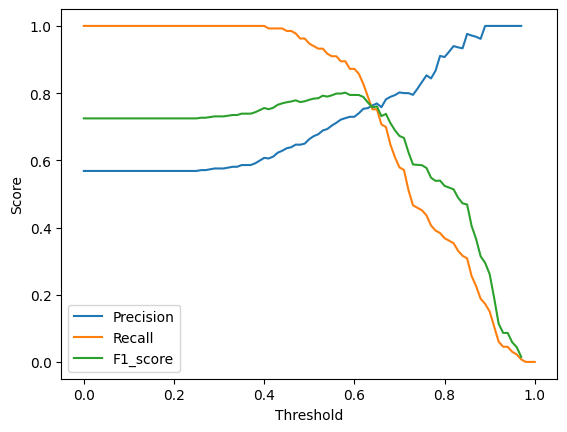

In [26]:
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_score, label='F1_score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [35]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.drop('converted', axis=1).to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [36]:
def predict(df, dv, model):
    dicts = df.drop('converted', axis=1).to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [38]:
n_splits = 5
scores = []
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full):
    df_train = df_full.iloc[train_idx]
    df_val = df_full.iloc[val_idx]

    y_train = df_train['converted']
    y_val = df_val['converted']

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [42]:
np.std(scores)

np.float64(0.03580711942905165)

In [47]:
n_splits = 5
scores = []
for i in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full):
        df_train = df_full.iloc[train_idx]
        df_val = df_full.iloc[val_idx]
    
        y_train = df_train['converted']
        y_val = df_val['converted']
    
        dv, model = train(df_train, y_train, C=i)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(f"the C is {i} and the mean is {np.mean(scores)} and the std {np.std(scores)}")

the C is 1e-06 and the mean is 0.560207852870275 and the std 0.023798316620649906
the C is 0.001 and the mean is 0.7135429423189074 and the std 0.15558921067164053
the C is 1 and the mean is 0.7497315998317072 and the std 0.13851097231161522


In [45]:
scores

[0.5572098563239782,
 0.5191961842208147,
 0.5894909688013137,
 0.5582191780821917,
 0.5769230769230769,
 0.8608650338718081,
 0.8967081085307685,
 0.822816482915005,
 0.8539850560398504,
 0.9000154774802662,
 0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]